# Deep Brain Vision(DBV) Brain Tumor detection  And classification Using Computer Vision


DBV Project is mainly for Brain Tumor Detction And classification using computer vision and using multi model integration techniques

Install and Import Libraries

In [1]:
!pip install opencv-python-headless imgaug
!pip install roboflow
!pip install ultralytics


from multiprocessing import Pool, cpu_count
from roboflow import Roboflow
import os
import numpy as np
from PIL import Image, ImageEnhance
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import random
from scipy import ndimage
import shutil
from imgaug import augmenters as iaa
import torch
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, BboxParams
import subprocess
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)


In [2]:
rf = Roboflow(api_key="s0usIb1HAC6nEWOv2Kse")
project = rf.workspace("ali-rostami").project("labeled-mri-brain-tumor-dataset")
version = project.version(1)
dataset = version.download("yolov8")

data_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1"

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.48, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Labeled-MRI-Brain-Tumor-Dataset-1 in yolov8:: 100%|██████████| 4898/4898 [00:00<00:00, 7017.54it/s]


In [3]:
#Check Folder Contents
train_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train'
test_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/test'
val_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid'

# Check the contents to verify
print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))
print("Validation folder contents:", os.listdir(val_path))

Train folder contents: ['images', 'labels']
Test folder contents: ['images', 'labels']
Validation folder contents: ['images', 'labels']


Load Images and Labels

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return np.array(images)

def load_labels_from_folder(folder):
    labels = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r') as file:
            label = file.read().strip()
            labels.append(label)
    return np.array(labels)

Load Images and Check Shapes

In [5]:
# Paths to the image folders
train_images_folder = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train/images'
test_images_folder = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/test/images'
val_images_folder = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid/images'

# Load images
train_images = load_images_from_folder(train_images_folder)
test_images = load_images_from_folder(test_images_folder)
val_images = load_images_from_folder(val_images_folder)

# Check shapes
print("Train Images shape:", train_images.shape)
print("Test Images shape:", test_images.shape)
print("Validation Images shape:", val_images.shape)


Train Images shape: (1695, 640, 640, 3)
Test Images shape: (246, 640, 640, 3)
Validation Images shape: (502, 640, 640, 3)


Display Sample Images

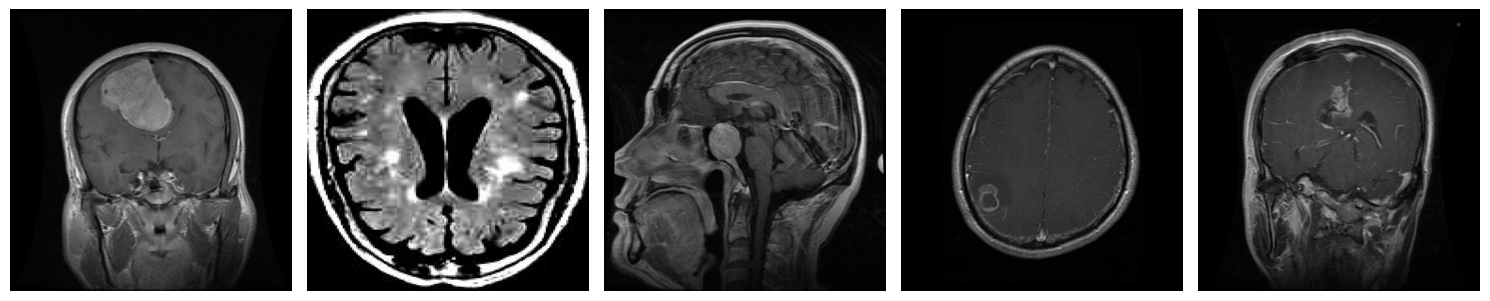

In [6]:
train_images_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train/images'
image_files = os.listdir(train_images_path)
num_images_to_plot = 5
selected_images = random.sample(image_files, num_images_to_plot)

plt.figure(figsize=(15, 10))
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(train_images_path, image_name)
    image = Image.open(image_path)

    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Augmentation

In [7]:
# Define the augmentation pipeline
def get_transforms():
    return Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        RandomBrightnessContrast(p=0.5)
    ], bbox_params=BboxParams(format='yolo', min_area=0.1, min_visibility=0.3, label_fields=['labels']))

# Function to process and save a single image and label
def process_single_file(args):
    data_path, save_path, filename, augment_data = args
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    image_filename = filename
    label_filename = filename.replace('.jpg', '.txt')

    # Load image
    image_path = os.path.join(images_path, image_filename)
    image = cv2.imread(image_path)

    # Load labels
    label_path = os.path.join(labels_path, label_filename)
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            labels.append([int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])

    # Save original image and labels
    save_image_path = os.path.join(save_path, 'images', image_filename)
    save_label_path = os.path.join(save_path, 'labels', label_filename)
    cv2.imwrite(save_image_path, image)
    shutil.copy(label_path, save_label_path)

    if augment_data:
        # Perform augmentations
        transformed = get_transforms()(image=image, bboxes=[x[1:] for x in labels], labels=[x[0] for x in labels])
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_labels = transformed['labels']

        # Save the transformed image and labels
        augmented_image_filename = f"aug_{image_filename}"
        augmented_label_filename = f"aug_{label_filename}"
        save_augmented_image_path = os.path.join(save_path, 'images', augmented_image_filename)
        save_augmented_label_path = os.path.join(save_path, 'labels', augmented_label_filename)
        cv2.imwrite(save_augmented_image_path, transformed_image)
        with open(save_augmented_label_path, 'w') as file:
            for label, bbox in zip(transformed_labels, transformed_bboxes):
                file.write(f"{label} {' '.join(map(str, bbox))}\n")

# Function to process and save images and labels in parallel
def process_and_save(data_path, save_path, augment_data=True):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    # Ensure directories exist
    os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'labels'), exist_ok=True)

    images = set([f for f in os.listdir(images_path) if f.endswith('.jpg')])
    labels = set([f.replace('.txt', '.jpg') for f in os.listdir(labels_path) if f.endswith('.txt')])

    # Process only files that have both an image and a corresponding label
    valid_files = images.intersection(labels)

    # Use multiprocessing to process files in parallel
    num_workers = min(cpu_count(), len(valid_files))
    with Pool(num_workers) as pool:
        pool.map(process_single_file, [(data_path, save_path, filename, augment_data) for filename in valid_files])

# Define paths
base_data_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1"
save_base_folder = "/content/DBV_Data"

# Process each dataset part
for part in ['train', 'test', 'valid']:
    data_path = os.path.join(base_data_folder, part)
    save_path = os.path.join(save_base_folder, part)
    process_and_save(data_path, save_path)


In [8]:
# Define the base directory where data is stored
base_directory = "/content/DBV_Data"

# Parts to check (train, test, valid)
parts = ['train', 'test', 'valid']

# Loop through each part and print out the counts of images and labels
for part in parts:
    images_path = os.path.join(base_directory, part, 'images')
    labels_path = os.path.join(base_directory, part, 'labels')

    # Count the number of image files
    image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
    num_images = len(image_files)

    # Count the number of label files
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
    num_labels = len(label_files)

    # Print the counts
    print(f"Part: {part}")
    print(f"Number of images: {num_images}")
    print(f"Number of labels: {num_labels}")
    print()


Part: train
Number of images: 3390
Number of labels: 3390

Part: test
Number of images: 492
Number of labels: 492

Part: valid
Number of images: 1004
Number of labels: 1004



In [11]:
# Define the train folder
train_folder = 'DBV_Data/train/images'

# Function to extract class name from image name
def extract_class_name(image_name):
    if "me" in image_name:
        return "Meningioma"
    elif "gl" in image_name:
        return "Glioma"
    elif "no" in image_name:
        return "No Tumor"
    elif "pi" in image_name:
        return "Pituitary"
    else:
        return "Unknown"




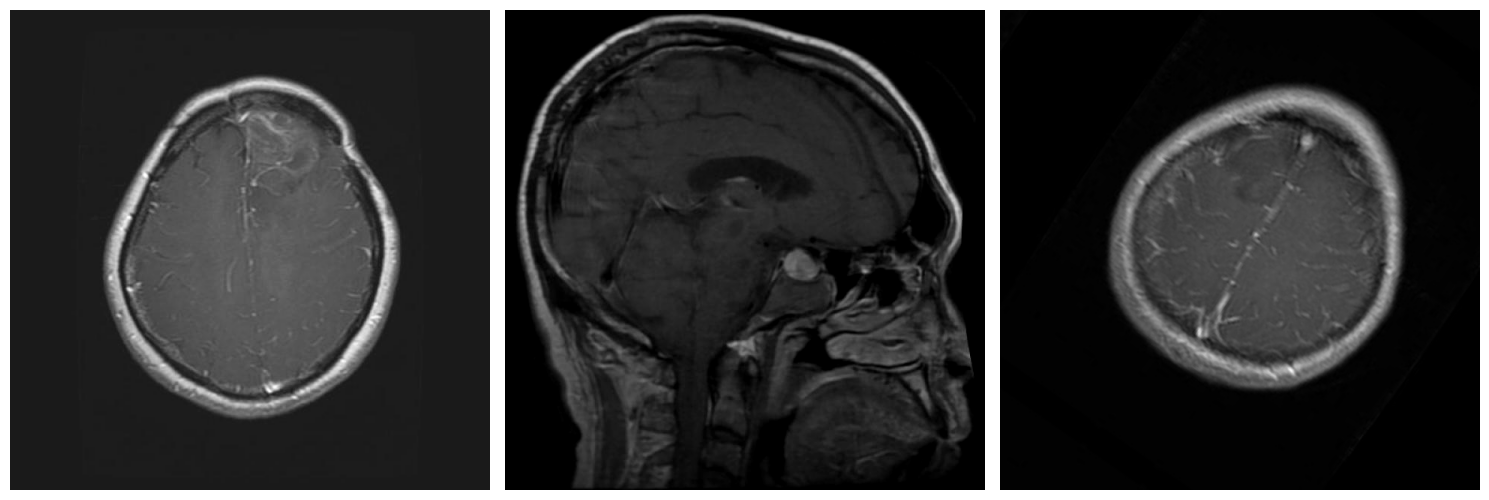

In [13]:
# plot sample of data augmentation

# Load images
images_path = '/content/DBV_Data/train/images'
image_files = os.listdir(images_path)
selected_images = random.sample(image_files, 3)

# Define augmentation pipeline
transform = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    RandomBrightnessContrast(p=0.5)
])

# Apply augmentation and plot
plt.figure(figsize=(15, 10))
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_path, image_name)
    image = Image.open(image_path)

    # Apply augmentation
    transformed = transform(image=np.array(image))
    transformed_image = transformed['image']

    plt.subplot(1, len(selected_images), i+1)
    plt.imshow(transformed_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


# YoloV8

In [15]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=60 imgsz=640

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Labeled-MRI-Brain-Tumor-Dataset-1/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

In [16]:
# Define paths
model_path = '/content/runs/detect/train2/weights/best.pt'
source_dir = '/content/DBV_Data/test/images/'
output_dir = '/content/yolov8_output/'

# Create directories for predicted images and labels
output_images_dir = os.path.join(output_dir, 'images')
output_labels_dir = os.path.join(output_dir, 'labels')
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Command template for running detection
command_template = (
    "yolo task=detect mode=predict model={} conf=0.2 source={{}}".format(model_path)
)

# Run YOLO detection task for all images in the source directory
for image_file in os.listdir(source_dir):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(source_dir, image_file)
        command = command_template.format(image_path)
        print("Running:", command)
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        print(result.stdout)  # Print standard output
        print(result.stderr)  # Print standard error if any


print("Detection completed for all test images.")


Running: yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt conf=0.2 source=/content/DBV_Data/test/images/aug_Tr-me_0194_jpg.rf.de84814eeddc99c52f384852cab10c9e.jpg
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/DBV_Data/test/images/aug_Tr-me_0194_jpg.rf.de84814eeddc99c52f384852cab10c9e.jpg: 640x640 (no detections), 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 71.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


Running: yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt conf=0.2 source=/content/DBV_Data/test/images/aug_Tr-me_0160_jpg.rf.1f4ca673d246a990414e02bba94d28e2.jpg
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 lay

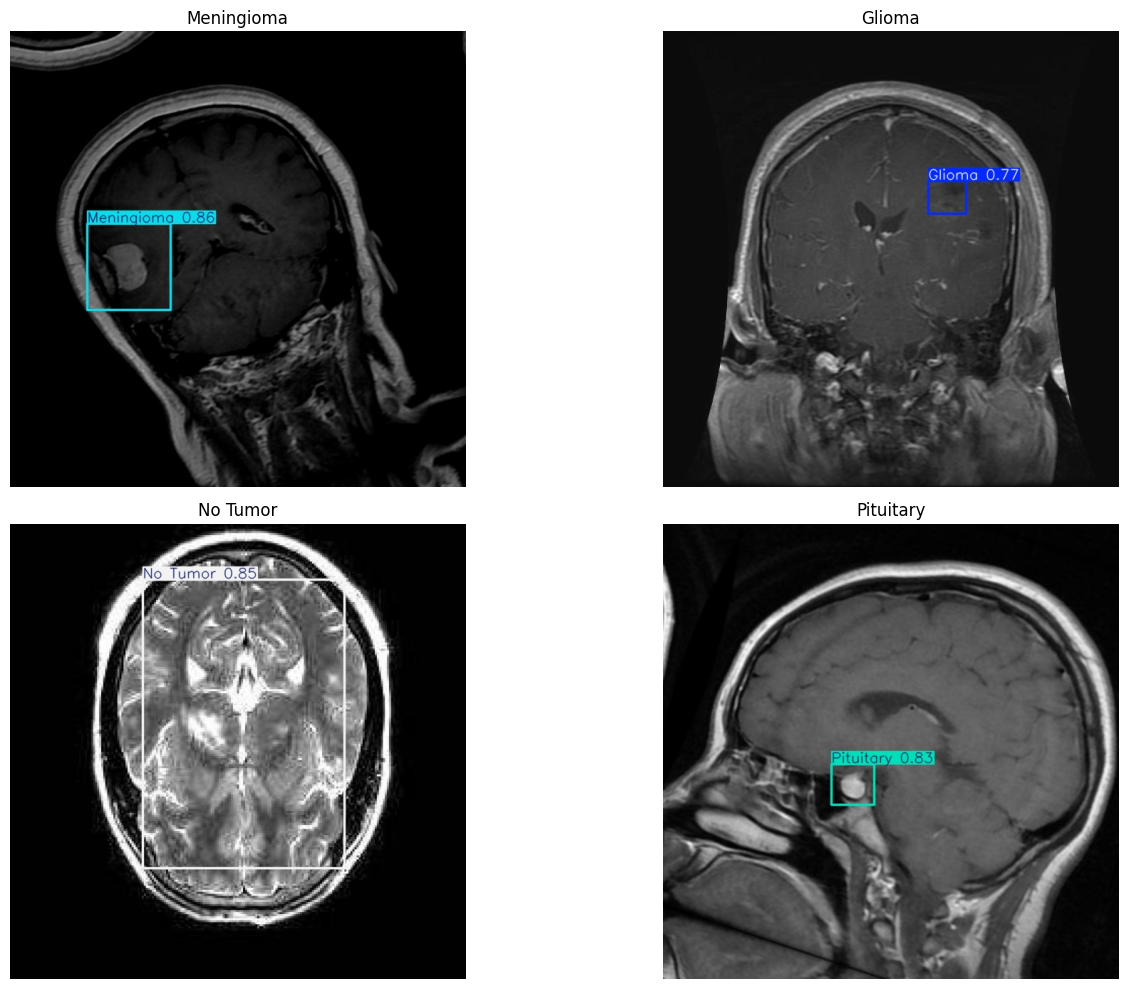

In [44]:
# Define the output directory where images are stored
output_dir = '/content/yolov8_output'

# Get a list of all image files in the output directory
image_files = os.listdir(os.path.join(output_dir, 'images'))

# Filter the image files to only include those that end with '.jpg'
image_files = [f for f in image_files if f.endswith('.jpg')]

# Create a list of class names
class_names = ['Meningioma', 'Glioma', 'No Tumor', 'Pituitary']

# Create a dictionary to store the sample images for each class
class_samples = {cls: [] for cls in class_names}

# Iterate through the image files and randomly select one image per class
for image_file in image_files:
    # Extract the class name from the image file name
    class_name = extract_class_name(image_file)

    # Add the image file to the corresponding class in the dictionary
    if class_name in class_names:
        class_samples[class_name].append(image_file)

# Plot the sample images for each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    # Randomly select one image from the list for each class
    if class_samples[class_name]:
        random_image = random.choice(class_samples[class_name])
        image_path = os.path.join(output_dir, 'images', random_image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:

# Define paths
source_base_dir = '/content/runs/detect/'
target_dir = '/content/yolov8_output/'

# Create the target directories if they don't exist
output_images_dir = os.path.join(target_dir, 'images')
os.makedirs(output_images_dir, exist_ok=True)

# Find all prediction directories
predict_dirs = [d for d in os.listdir(source_base_dir) if d.startswith('predict') and os.path.isdir(os.path.join(source_base_dir, d))]
predict_dirs.sort()  # Ensure the directories are sorted; Python's sort is alphanumeric

# Copy files from each predict directory to the output images directory
for predict_dir in predict_dirs:
    full_predict_dir = os.path.join(source_base_dir, predict_dir)
    for file_name in os.listdir(full_predict_dir):
        if file_name.endswith('.jpg'):
            source_file_path = os.path.join(full_predict_dir, file_name)
            output_file_path = os.path.join(output_images_dir, file_name)
            shutil.copy(source_file_path, output_file_path)
            print(f"Copied {source_file_path} to {output_file_path}")

print("All predictions copied to the output images directory:", output_images_dir)


Copied /content/runs/detect/predict/aug_Tr-me_0194_jpg.rf.de84814eeddc99c52f384852cab10c9e.jpg to /content/yolov8_output/images/aug_Tr-me_0194_jpg.rf.de84814eeddc99c52f384852cab10c9e.jpg
Copied /content/runs/detect/predict10/aug_Tr-pi_0562_jpg.rf.b7d629887a6dc9b22011837fafad9948.jpg to /content/yolov8_output/images/aug_Tr-pi_0562_jpg.rf.b7d629887a6dc9b22011837fafad9948.jpg
Copied /content/runs/detect/predict100/Tr-gl_0278_jpg.rf.2d2e5b394b899b5ee8e82a5d1487ddf0.jpg to /content/yolov8_output/images/Tr-gl_0278_jpg.rf.2d2e5b394b899b5ee8e82a5d1487ddf0.jpg
Copied /content/runs/detect/predict101/Tr-gl_0528_jpg.rf.aa863973db113d6c9a86c83d7756e0c3.jpg to /content/yolov8_output/images/Tr-gl_0528_jpg.rf.aa863973db113d6c9a86c83d7756e0c3.jpg
Copied /content/runs/detect/predict102/aug_Tr-gl_0129_jpg.rf.b7e1bee7f70e8dbd91dcfb6ab7efc569.jpg to /content/yolov8_output/images/aug_Tr-gl_0129_jpg.rf.b7e1bee7f70e8dbd91dcfb6ab7efc569.jpg
Copied /content/runs/detect/predict103/Tr-me_0161_jpg.rf.e488e823e3c93

In [21]:
# Copy labels to the output labels directory
labels_source_dir = '/content/DBV_Data/test/labels'
for label_file in os.listdir(labels_source_dir):
    if label_file.endswith('.txt'):
        shutil.copy(os.path.join(labels_source_dir, label_file), output_labels_dir)

print("Labels copied to the output directory.")


Labels copied to the output directory.


In [22]:
# check no of labels and images in /content/yolov8_output/ to make sure there is no issues through detctions or move data

# Define the output directory
output_dir = "/content/yolov8_output/"

# Get lists of image and label files
image_files = [f for f in os.listdir(os.path.join(output_dir, "images")) if f.endswith(".jpg")]
label_files = [f for f in os.listdir(os.path.join(output_dir, "labels")) if f.endswith(".txt")]

# Print the number of images and labels
print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")


Number of images: 492
Number of labels: 492


# Extract ROI

In [23]:


# Define the directory containing the images
image_dir = '/content/yolov8_output/images'

# Define the directory containing the label files
label_dir = '/content/yolov8_output/labels'

# Define the directory to save the extracted ROIs
roi_dir = '/content/brain_roi/'

# Create the directory for saving ROIs if it doesn't exist
os.makedirs(roi_dir, exist_ok=True)

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Process each image
for image_file in image_files:
    # Construct the paths for the image and its corresponding label file
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))

    # Read the image
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Unable to load image from '{image_path}'")
        continue

    # Read the bounding box information from the label file
    with open(label_path, 'r') as f:
        lines = f.read().splitlines()
    bboxes = []
    for line in lines:
        parts = line.split(' ')
        class_id = int(parts[0])
        # Normalize bounding box coordinates if necessary
        x_center, y_center, width, height = map(float, parts[1:])
        x1 = max(0, x_center - width / 2)
        y1 = max(0, y_center - height / 2)
        x2 = min(1, x_center + width / 2)
        y2 = min(1, y_center + height / 2)
        bbox = [x1, y1, x2, y2]
        bboxes.append((class_id, bbox))  # Store class_id along with the bbox

    # Extract the ROIs from the image
    for class_id, bbox in bboxes:
        x1, y1, x2, y2 = bbox

        # Convert bounding box coordinates to pixel coordinates
        h, w, _ = image.shape
        x1_pixel, y1_pixel = int(x1 * w), int(y1 * h)
        x2_pixel, y2_pixel = int(x2 * w), int(y2 * h)

        # Extract the ROI if bounding box is valid
        if x1_pixel < x2_pixel and y1_pixel < y2_pixel:
            roi = image[y1_pixel:y2_pixel, x1_pixel:x2_pixel]

            # Save the ROI if it's not empty
            if roi.size != 0:
                roi_filename = f"{os.path.splitext(image_file)[0]}_{class_id}_{bboxes.index((class_id, bbox))}.jpg"
                roi_path = os.path.join(roi_dir, roi_filename)
                cv2.imwrite(roi_path, roi)
            else:
                print(f"Warning: Empty ROI for bounding box {bbox}")
        else:
            print(f"Warning: Invalid bounding box coordinates {bbox}")

print("ROIs extracted successfully and saved to:", roi_dir)


ROIs extracted successfully and saved to: /content/brain_roi/


ROI_Augmentaion

In [24]:
# Define augmentation pipeline
def get_transforms():
    return Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        RandomBrightnessContrast(p=0.5)
    ])

# Function to augment and save images
def augment_and_save_images(data_path, save_path, num_augmentations=3):
    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Get list of images in the directory
    images = [f for f in os.listdir(data_path) if f.endswith('.jpg')]

    for image_filename in images:
        # Load image
        image_path = os.path.join(data_path, image_filename)
        image = cv2.imread(image_path)

        # Save original image
        save_image_path = os.path.join(save_path, image_filename)
        cv2.imwrite(save_image_path, image)

        for i in range(num_augmentations):
            # Perform augmentations
            transformed = get_transforms()(image=image)
            transformed_image = transformed['image']

            # Save augmented image
            augmented_image_filename = f"{os.path.splitext(image_filename)[0]}_aug_{i}.jpg"
            save_augmented_image_path = os.path.join(save_path, augmented_image_filename)
            cv2.imwrite(save_augmented_image_path, transformed_image)

# Define paths
roi_dir = '/content/brain_roi'
augmented_data_folder = '/content/augmented_brain_roi'

# Perform augmentation and save images
augment_and_save_images(roi_dir, augmented_data_folder)

# Verify contents of the augmented data folder
print("Original and augmented images have been saved in:", augmented_data_folder)


Original and augmented images have been saved in: /content/augmented_brain_roi


# ResNet50

We Already Trained ResNet50 Classification Model in same data set and save these model to use in The Integration Step

# Model Integration

In [25]:
# Define the path to the saved model
model_path = '/content/resnet50_tumorclassification_model (1).pth'

In [26]:
# Define a custom classifier with 4 output features
class CustomClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomClassifier, self).__init__()
        self.fc = nn.Linear(2048, num_classes)  # Modify the output features to match custom model

    def forward(self, x):
        x = self.fc(x)
        return x

In [27]:
# Define a function to get class name from class index
def get_class_name(class_idx):
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    return class_names[class_idx]

In [28]:
# Load the ResNet model
resnet = models.resnet50(pretrained=False)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


In [29]:
# Replace the fully connected layer with the custom classifier
resnet.fc = CustomClassifier()

In [30]:
# Load the saved model
saved_model_state_dict = torch.load(model_path)

In [31]:
# Modify the keys of the state dictionary to match the model architecture
modified_state_dict = {}
for name, param in saved_model_state_dict.items():
    if name.startswith('fc.'):
        name = 'fc.fc' + name[2:]  # Modify the key to match the model architecture
    modified_state_dict[name] = param

# Load the modified state dictionary into the ResNet model
resnet.load_state_dict(modified_state_dict)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ResNet model onto the device
resnet = resnet.to(device)

In [32]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [33]:
def classify_single_image(image_path):
    img = Image.open(image_path).convert('RGB')



    img_t = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = resnet(img_t)
        _, predicted = torch.max(output, 1)

    predicted_class_name = get_class_name(predicted.item())
    return predicted_class_name


In [34]:
# Classify ROI images and calculate accuracy
roi_dir = '/content/augmented_brain_roi'
roi_images = [f for f in os.listdir(roi_dir) if f.endswith('.jpg')]

# Initialize counters
total_images = len(roi_images)
misclassifications = 0

# Sample some images for inspection
sample_size = 50
sample_images = random.sample(roi_images, sample_size)

for image_file in sample_images:
    image_path = os.path.join(roi_dir, image_file)
    predicted_class = classify_single_image(image_path)
    ground_truth_class = extract_class_name(image_file)
    if predicted_class != ground_truth_class:
        misclassifications += 1

# Calculate accuracy
accuracy = (total_images - misclassifications) / total_images * 100
print(f"Total images: {total_images}")
print(f"Misclassified images: {misclassifications}")
print(f"Accuracy: {accuracy:.2f}%")


Total images: 2000
Misclassified images: 32
Accuracy: 98.40%
